### Importing the Necessary Libraries

In [88]:
# Basic ML Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow Libraries
import tensorflow as tf

### Splitting the Dataset into Training Set and Test Set

In [89]:
trainDS = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/COVID_19_Chest_CT_1/',
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = None,
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (224, 224),
    shuffle = False,
    seed = 123,
    validation_split = 0.2,
    subset = 'training',
    interpolation = 'bilinear'
)

testDS = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/COVID_19_Chest_CT_1/',
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = None,
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (224, 224),
    shuffle = False,
    seed = 123, 
    validation_split = 0.2,
    subset = 'validation',
    interpolation = 'bilinear'
)

Found 2481 files belonging to 2 classes.
Using 1985 files for training.
Found 2481 files belonging to 2 classes.
Using 496 files for validation.


### Preprocessing the Dataset with Data Augmentation

In [90]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomBrightness(factor=0.2, value_range=(0, 255)),
        tf.keras.layers.RandomContrast(factor=0.2),
        tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(factor=0.2, fill_mode="reflect"),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.Rescaling(1./255)
    ]
)

augmentedTrainDS = trainDS.map(lambda x, y: (data_augmentation(x), y))
# augmentedTestDS = testDS.map(lambda x, y: (data_augmentation(x), y))

# trainImages, trainLabels = next(iter(augmentedTrainDS))
# testImages, testLabels = next(iter(testDS))
# print(type(trainImages))

# # Converting the MapDataset to Numpy Array
# augmentedTrainDS = tf.data.Dataset.from_tensor_slices(trainImages).shuffle(1000)
# testDS = tf.data.Dataset.from_tensor_slices(testImages).shuffle(1000)

# augmentedTrainDS = np.stack(list(augmentedTrainDS))
# testDS = np.stack(list(testDS))
# print(type(augmentedTrainDS), augmentedTrainDS.shape)

### Visualizing the Image Dataset

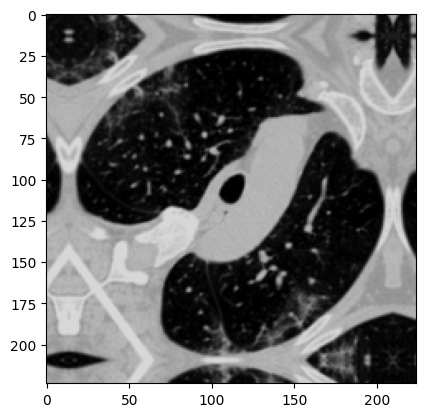

In [91]:
trainImages, trainLabels = next(iter(augmentedTrainDS))
plt.imshow(trainImages[0])

### Creating the Base model

In [92]:
inputs = tf.keras.Input(shape=(224, 224, 3))
densenet = tf.keras.applications.densenet.DenseNet121(include_top=False, weights="imagenet", input_shape=(224, 224, 3), classes=1000, classifier_activation="softmax")(inputs)
densenet = tf.keras.layers.GlobalAveragePooling2D()(densenet)
densenet = tf.keras.layers.BatchNormalization()(densenet)
densenet = tf.keras.layers.Dropout(rate=0.5)(densenet)
densenet = tf.keras.layers.Dense(units=1000, activation="relu")(densenet)
densenet = tf.keras.layers.BatchNormalization()(densenet)
densenet = tf.keras.layers.Dropout(rate=0.5)(densenet)
outputs = tf.keras.layers.Dense(units=len(trainDS.class_names), activation="softmax")(densenet)

finalModel = tf.keras.Model(inputs=inputs, outputs=outputs, name="DenseNet-121Model")

### Compile the Created CNN Model

In [96]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1)
finalModel.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.AUC()])
finalModel.summary()

Model: "DenseNet-121Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_5   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_8 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 1000)        

### Training the CNN Model on the Dataset

In [97]:
annealer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, verbose=1, min_lr=1e-3)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="SavedModels/Pretrained_DenseNet121/DenseNet121_BestModel.h5", monitor='val_loss', verbose=1, save_freq='epoch')
modelHistory = finalModel.fit(x=augmentedTrainDS, steps_per_epoch=trainImages.shape[0], epochs=10, verbose=2, callbacks=[annealer, checkpoint], validation_data=testDS)

Epoch 1/10
